In [1]:
import torch
from torch.autograd import Function
from torch.autograd import Variable

In [2]:
from numpy.fft import rfft2, irfft2


class BadFFTFunction(Function):

    def forward(self, input):
        numpy_input = input.numpy()
        result = abs(rfft2(numpy_input))
        return torch.FloatTensor(result)

    def backward(self, grad_output):
        numpy_go = grad_output.numpy()
        result = irfft2(numpy_go)
        return torch.FloatTensor(result)

# since this layer does not have any parameters, we can
# simply declare this as a function, rather than as an nn.Module class


def incorrect_fft(input):
    return BadFFTFunction()(input)

In [3]:
input = Variable(torch.randn(8, 8), requires_grad=True)
result = incorrect_fft(input)
print(result.data)
result.backward(torch.randn(result.size()))
print(input.grad)


 17.2923   5.7564   8.3867   4.0447   3.1630
  1.7771   6.5101   1.5998   7.4871  15.9823
 15.7160  12.4507   2.4195   4.9945   1.8347
 11.6155   2.5347   9.4327   9.3158  10.2593
 11.4161   9.5557  13.2168   5.9696  10.2380
 11.6155   0.4103   8.3617   1.3750  10.2593
 15.7160  10.6427   9.3367   4.7530   1.8347
  1.7771  13.4049   2.0820   5.0718  15.9823
[torch.FloatTensor of size 8x5]

Variable containing:
-0.0922 -0.0348 -0.0895  0.0130  0.3184  0.0130 -0.0895 -0.0348
-0.0691 -0.1866 -0.0630  0.1011 -0.1213  0.0125  0.1437  0.1539
 0.1855  0.0110 -0.2669  0.1334 -0.0375  0.3123  0.0082  0.1211
-0.0822  0.2366 -0.0813 -0.1058  0.0673  0.0311 -0.0332  0.0136
 0.0185  0.0172 -0.0829 -0.0352  0.1292 -0.0352 -0.0829  0.0172
-0.0822  0.0136 -0.0332  0.0311  0.0673 -0.1058 -0.0813  0.2366
 0.1855  0.1211  0.0082  0.3123 -0.0375  0.1334 -0.2669  0.0110
-0.0691  0.1539  0.1437  0.0125 -0.1213  0.1011 -0.0630 -0.1866
[torch.FloatTensor of size 8x8]



In [4]:
from scipy.signal import convolve2d, correlate2d
from torch.nn.modules.module import Module
from torch.nn.parameter import Parameter


In [5]:
class ScipyConv2dFunction(Function):

    def forward(self, input, filter):
        result = correlate2d(input.numpy(), filter.numpy(), mode='valid')
        self.save_for_backward(input, filter)
        return torch.FloatTensor(result)

    def backward(self, grad_output):
        input, filter = self.saved_tensors
        grad_input = convolve2d(grad_output.numpy(), filter.t().numpy(), mode='full')
        grad_filter = convolve2d(input.numpy(), grad_output.numpy(), mode='valid')
        return torch.FloatTensor(grad_input), torch.FloatTensor(grad_filter)

In [6]:
class ScipyConv2d(Module):

    def __init__(self, kh, kw):
        super(ScipyConv2d, self).__init__()
        self.filter = Parameter(torch.randn(kh, kw))

    def forward(self, input):
        return ScipyConv2dFunction()(input, self.filter)

In [7]:
module = ScipyConv2d(3, 3)
print(list(module.parameters()))
input = Variable(torch.randn(10, 10), requires_grad=True)
output = module(input)
print(output)
output.backward(torch.randn(8, 8))
print(input.grad)

[Parameter containing:
-1.6986  0.8522 -0.4432
-1.4637 -0.3282  0.2671
-1.2233 -1.4647 -0.5864
[torch.FloatTensor of size 3x3]
]
Variable containing:
-2.1822 -1.8873  2.2994 -1.2920  2.8307  5.0289 -0.0634  3.7611
-5.6616 -0.8410 -0.4788  1.4982 -3.8187  1.5445 -1.9139 -1.1134
 1.1274  1.9181 -1.7952 -1.1012 -1.7465 -0.3993  3.2776  1.2853
-2.9016  5.2304  1.1896  1.0150 -1.7656 -3.6171  0.6195 -4.1619
-2.3726  5.5362  2.3629  0.4653 -0.5915  0.0086  3.3891 -1.7158
 0.1439  1.4896  3.6193  2.2191 -3.3070 -2.9945  1.0419 -3.1140
 1.1060  0.2568 -0.2517  2.6548 -1.4989  1.0803  4.4348  1.2920
 1.2022  3.9920 -4.4783  0.2658  0.2797  4.0285  3.1188  4.5930
[torch.FloatTensor of size 8x8]

Variable containing:
-1.6104 -1.9201 -0.4341 -0.3714 -3.0806 -3.8348  0.0590 -1.2131 -0.8149 -2.2876
 3.0842  2.5676  2.2995  5.1260  6.6330 -0.0035 -2.8158  7.3083  7.1229  0.7417
-1.4032  0.7879  1.0029 -1.6019  2.5267  4.5817  1.5662 -6.1428  1.7290  0.9708
 0.0869 -0.3006  4.1909  3.3346 -0.4504  0.5

In [8]:
import torch
from torch.autograd import Variable

"""
A fully-connected ReLU network with one hidden layer, trained to predict y from x
by minimizing squared Euclidean distance.
This implementation defines the model as a custom Module subclass. Whenever you
want a model more complex than a simple sequence of existing Modules you will
need to define your model this way.
"""

class TwoLayerNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(TwoLayerNet, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        """
        In the forward function we accept a Variable of input data and we must return
        a Variable of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Variables.
        """
        h_relu = self.linear1(x).clamp(min=0)
        y_pred = self.linear2(h_relu)
        return y_pred


# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random Tensors to hold inputs and outputs, and wrap them in Variables
x = Variable(torch.randn(N, D_in))
y = Variable(torch.randn(N, D_out), requires_grad=False)

# Construct our model by instantiating the class defined above
model = TwoLayerNet(D_in, H, D_out)

# Construct our loss function and an Optimizer. The call to model.parameters()
# in the SGD constructor will contain the learnable parameters of the two
# nn.Linear modules which are members of the model.
criterion = torch.nn.MSELoss(size_average=False)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)
for t in range(500):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x)

    # Compute and print loss
    loss = criterion(y_pred, y)
    print(t, loss.data[0])

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
optimizer.step()

0 671.4768676757812
1 671.4768676757812
2 671.4768676757812
3 671.4768676757812
4 671.4768676757812
5 671.4768676757812
6 671.4768676757812
7 671.4768676757812
8 671.4768676757812
9 671.4768676757812
10 671.4768676757812
11 671.4768676757812
12 671.4768676757812
13 671.4768676757812
14 671.4768676757812
15 671.4768676757812
16 671.4768676757812
17 671.4768676757812
18 671.4768676757812
19 671.4768676757812
20 671.4768676757812
21 671.4768676757812
22 671.4768676757812
23 671.4768676757812
24 671.4768676757812
25 671.4768676757812
26 671.4768676757812
27 671.4768676757812
28 671.4768676757812
29 671.4768676757812
30 671.4768676757812
31 671.4768676757812
32 671.4768676757812
33 671.4768676757812
34 671.4768676757812
35 671.4768676757812
36 671.4768676757812
37 671.4768676757812
38 671.4768676757812
39 671.4768676757812
40 671.4768676757812
41 671.4768676757812
42 671.4768676757812
43 671.4768676757812
44 671.4768676757812
45 671.4768676757812
46 671.4768676757812
47 671.4768676757812
48

431 671.4768676757812
432 671.4768676757812
433 671.4768676757812
434 671.4768676757812
435 671.4768676757812
436 671.4768676757812
437 671.4768676757812
438 671.4768676757812
439 671.4768676757812
440 671.4768676757812
441 671.4768676757812
442 671.4768676757812
443 671.4768676757812
444 671.4768676757812
445 671.4768676757812
446 671.4768676757812
447 671.4768676757812
448 671.4768676757812
449 671.4768676757812
450 671.4768676757812
451 671.4768676757812
452 671.4768676757812
453 671.4768676757812
454 671.4768676757812
455 671.4768676757812
456 671.4768676757812
457 671.4768676757812
458 671.4768676757812
459 671.4768676757812
460 671.4768676757812
461 671.4768676757812
462 671.4768676757812
463 671.4768676757812
464 671.4768676757812
465 671.4768676757812
466 671.4768676757812
467 671.4768676757812
468 671.4768676757812
469 671.4768676757812
470 671.4768676757812
471 671.4768676757812
472 671.4768676757812
473 671.4768676757812
474 671.4768676757812
475 671.4768676757812
476 671.47

In [9]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from copy import deepcopy
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.transforms as T


env = gym.make('CartPole-v0').unwrapped

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor


In [10]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [58]:
class DQN(nn.Module):

    def __init__(self):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        self.hid = nn.Linear(448, 448)
        self.head = nn.Linear(448, 2)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.hid(x.view(x.size(0), -1))
        return self.head(x)

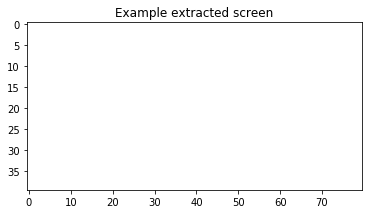

In [59]:
resize = T.Compose([T.ToPILImage(),
                    T.Scale(40, interpolation=Image.CUBIC),
                    T.ToTensor()])

# This is based on the code from gym.
screen_width = 600


def get_cart_location():
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART


def get_screen():
    screen = env.render(mode='rgb_array').transpose(
        (2, 0, 1))  # transpose into torch order (CHW)
    # Strip off the top and bottom of the screen
    screen = screen[:, 160:320]
    view_width = 320
    cart_location = get_cart_location()
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]
    # Convert to float, rescare, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0).type(Tensor)

env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()


In [60]:
BATCH_SIZE = 100
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200

model = DQN()

if use_cuda:
    model.cuda()

optimizer = optim.RMSprop(model.parameters())
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        return model(
            Variable(state, volatile=True).type(FloatTensor)).data.max(1)[1].view(1, 1)
    else:
        return LongTensor([[random.randrange(2)]])


episode_durations = []


def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.FloatTensor(episode_durations)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())


In [61]:
last_sync = 0

Transition = namedtuple('Transition',
                        ('state', 'action', 'reward', 'next_state', ))

def optimize_model():
    global last_sync
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see http://stackoverflow.com/a/19343/3343043 for
    # detailed explanation).
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = ByteTensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)))

    # We don't want to backprop through the expected action values and volatile
    # will save us on temporarily changing the model parameters'
    # requires_grad to False!
    non_final_next_states = Variable(torch.cat([s for s in batch.next_state
                                                if s is not None]),
                                     volatile=True)
    state_batch = Variable(torch.cat(batch.state))
    action_batch = Variable(torch.cat(batch.action))
    reward_batch = Variable(torch.cat(batch.reward))

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken
    state_action_values = model(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    next_state_values = Variable(torch.zeros(BATCH_SIZE).type(Tensor))
    next_state_values[non_final_mask] = model(non_final_next_states).max(1)[0]
    # Now, we don't want to mess up the loss with a volatile flag, so let's
    # clear it. After this, we'll just end up with a Variable that has
    # requires_grad=False
    next_state_values.volatile = False
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in model.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

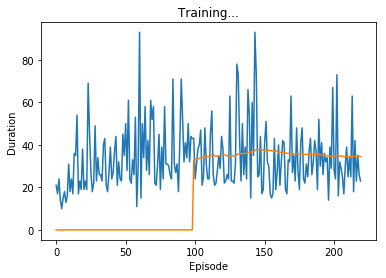

Complete


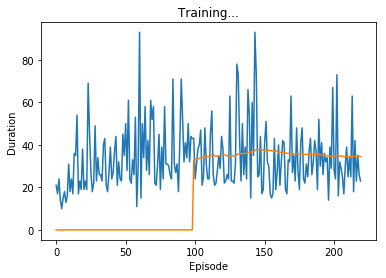

In [63]:
num_episodes = 200
for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    for t in count():
        # Select and perform an action
        action = select_action(state)
        _, reward, done, _ = env.step(action[0, 0])
        reward = Tensor([reward])

        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
env.render(close=True)
env.close()
plt.ioff()
plt.show()
